In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

In [2]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm
import logging
import random
import itertools
import utils
import matplotlib.pyplot as plt

# Hyperparameters

In [3]:
BOARD_SIZE = 7

In [4]:
DATA_AUGMENTATION = 8

In [5]:
NUM_EPISODES = 20000
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 1 * DATA_AUGMENTATION * MAX_STEPS
REPLAY_MEM_SIZE = 1 * DATA_AUGMENTATION * MAX_STEPS

ACTOR_LEARNING_RATE = 1e-4
ACTOR_BETA_1 = 0.5
CRITIC_LEARNING_RATE = 1e-3
CRITIC_BETA_1 = 0.5

EPSILON = 0.01
EPSILON_DECAY = 0.99
EPSILON_MIN = 0.01

OPPONENT_UPDATE = 500
OPPONENT_EPSILON = 1

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [6]:
%%capture
!pip3 install -e gym-go

In [7]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='real')

# Replay Memory

In [8]:
from collections import deque

In [9]:
replay_mem = deque(maxlen=int(REPLAY_MEM_SIZE))

In [10]:
def add_to_replay_mem(state, action_1d, next_state, reward, done):
    """
    Adds original event, plus augmented versions of those events
    """
    
    for s, a, ns in list(zip(utils.all_orientations(state, BOARD_SIZE), 
                             utils.all_orientations(action_1d, BOARD_SIZE), 
                             utils.all_orientations(next_state, BOARD_SIZE))):
        replay_mem.append((s, a, ns, reward, done))

In [11]:
def get_batch_obs(index=None, size=BATCH_SIZE):
    '''
    Get a batch of orig_states, actions, states, rewards, terminals as np array out of replay memory
    '''
    
    # States were (BATCH_SIZE, 4, BOARD_SIZE, BOARD_SIZE)
    # Convert them to (BATCH_SIZE, BOARD_SIZE, BOARD_SIZE, 4)
    if index is None:
        batch = random.sample(replay_mem, size)
    else:
        batch = itertools.islice(replay_mem, index*BATCH_SIZE, (index+1)*BATCH_SIZE)
    batch = list(zip(*batch))
    states = np.array(list(batch[0]), dtype=np.float32).transpose(0,2,3,1)
    actions = np.array(list(batch[1]), dtype=np.int)
    next_states = np.array(list(batch[2]), dtype=np.float32).transpose(0,2,3,1)
    rewards = np.array(list(batch[3]), dtype=np.float32).reshape((-1,))
    terminals = np.array(list(batch[4]), dtype=np.uint8)
    
    return states, actions, next_states, rewards, terminals 

# Machine Learning Models

In [12]:
ACTOR_PATH = 'tmp/actor.h5'
CRITIC_PATH = 'tmp/critic.h5'

In [13]:
from tensorflow.keras import layers

In [14]:
def make_actor_critic(mode):
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="valid_moves")
    invalid_values = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="invalid_values")
    
    x = layers.Flatten()(inputs)
    
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    if mode == 'actor':
        move_probs = layers.Dense(128)(x)
        move_probs = layers.BatchNormalization()(move_probs)
        move_probs = layers.ReLU()(move_probs)
        move_probs = layers.Dense(50)(move_probs)
        move_probs = layers.BatchNormalization()(move_probs)
        move_probs = layers.ReLU()(move_probs)
        move_probs = layers.Add()([move_probs, invalid_values])
        move_probs = layers.Softmax(name="move_probs")(move_probs)
        out = move_probs
    else:
        move_vals = layers.Dense(128)(x)
        move_vals = layers.BatchNormalization()(move_vals)
        move_vals = layers.ReLU()(move_vals)
        move_vals = layers.Dense(50, activation="tanh")(move_vals)
        move_vals = layers.Multiply(name="move_vals")([move_vals, valid_inputs])
        out = move_vals

    model = tf.keras.Model(inputs=[inputs, valid_inputs, invalid_values], 
                           outputs=out, name=mode)
    return model

In [15]:
actor = make_actor_critic('actor')

In [16]:
actor.summary()

Model: "actor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          50432       flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256)          1024        dense[0][0]                      
______________________________________________________________________________________________

In [17]:
critic = make_actor_critic('critic')

In [18]:
critic.summary()

Model: "critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 256)          50432       flatten_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 256)          1024        dense_6[0][0]                    
_____________________________________________________________________________________________

In [19]:
opponent = tf.keras.models.clone_model(actor)

In [20]:
opponent.load_weights(ACTOR_PATH)

### Initialization of models 
should be random if the models are fresh

In [21]:
def forward_pass(states, network):
    """
    Since the neural nets take in more than one parameter, 
    this functions serves as a wrapper to forward pass the data through the networks
    """
    invalid_moves = utils.get_invalid_moves(states)
    invalid_values = utils.get_invalid_values(states)
    valid_moves = 1 - invalid_moves
    return network([states.astype(np.float32), 
                    valid_moves.astype(np.float32), 
                    invalid_values.astype(np.float32)])

In [22]:
def state_responses(states, taken_actions, next_states, rewards, terminals):
    """
    Returns a figure of plots on the states and the models responses on those states
    """
    move_probs = forward_pass(states, actor)
    move_vals = forward_pass(states, critic)
    state_vals = tf.reduce_sum(move_probs * move_vals, axis=1)
    
    num_states = states.shape[0]
    num_cols =4
    
    fig = plt.figure(figsize=(num_cols * 2.5, num_states * 2))
    for i in range(num_states):
        plt.subplot(num_states,num_cols,1 + num_cols*i)
        plt.axis('off')
        plt.title('Board')
        plt.imshow(states[i][:,:,[0,1,3]].astype(np.float))
        
        plt.subplot(num_states,num_cols, 2 + num_cols*i)
        utils.plot_move_distr('Critic', 100 * move_vals[i], scalar=100 * state_vals[i].numpy())

        plt.subplot(num_states,num_cols, 3 + num_cols*i)
        utils.plot_move_distr('Actor', 100 * move_probs[i], scalar=None)
        
        plt.subplot(num_states,num_cols, 4 + num_cols*i)
        plt.axis('off')
        plt.title('Taken Action: {}\n{:.0f}R {}T'
                  .format(utils.action_1d_to_2d(taken_actions[i], BOARD_SIZE), 
                                                         rewards[i], terminals[i]))
        plt.imshow(next_states[i][:,:,[0,1,3]].astype(np.float))

    plt.tight_layout()
    return fig

In [23]:
def sample_heatmaps(num_samples=2):
    states, actions, next_states, rewards, terminals = get_batch_obs(size=num_samples)
    
    # Add latest terminal state
    for (state, action, next_state, reward, terminal) in reversed(replay_mem):
        if terminal:
            states = np.concatenate([states, state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
            actions = np.append(actions, action)
            next_states = np.concatenate([next_states, next_state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
            rewards = np.append(rewards, reward)
            terminals = np.append(terminals, terminal)
            break
    # Add latest start state
    for (state, action, next_state, reward, terminal) in reversed(replay_mem):
        if np.sum(state[:2]) == 0:
            states = np.concatenate([states, state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
            actions = np.append(actions, action)
            next_states = np.concatenate([next_states, next_state.transpose(1,2,0)
                             .reshape((-1,BOARD_SIZE, BOARD_SIZE, 4))], axis=0)
            rewards = np.append(rewards, reward)
            terminals = np.append(terminals, terminal)
            break

    fig = state_responses(states, actions, next_states, rewards, terminals)
    return fig

In [24]:
state = go_env.reset()
first_action = (2,5)
second_action = (5,2)
first_state, reward, done, info = go_env.step(first_action)
second_state, reward, done, info = go_env.step(second_action)
add_to_replay_mem(state, utils.action_2d_to_1d(first_action, BOARD_SIZE), second_state, reward, done)

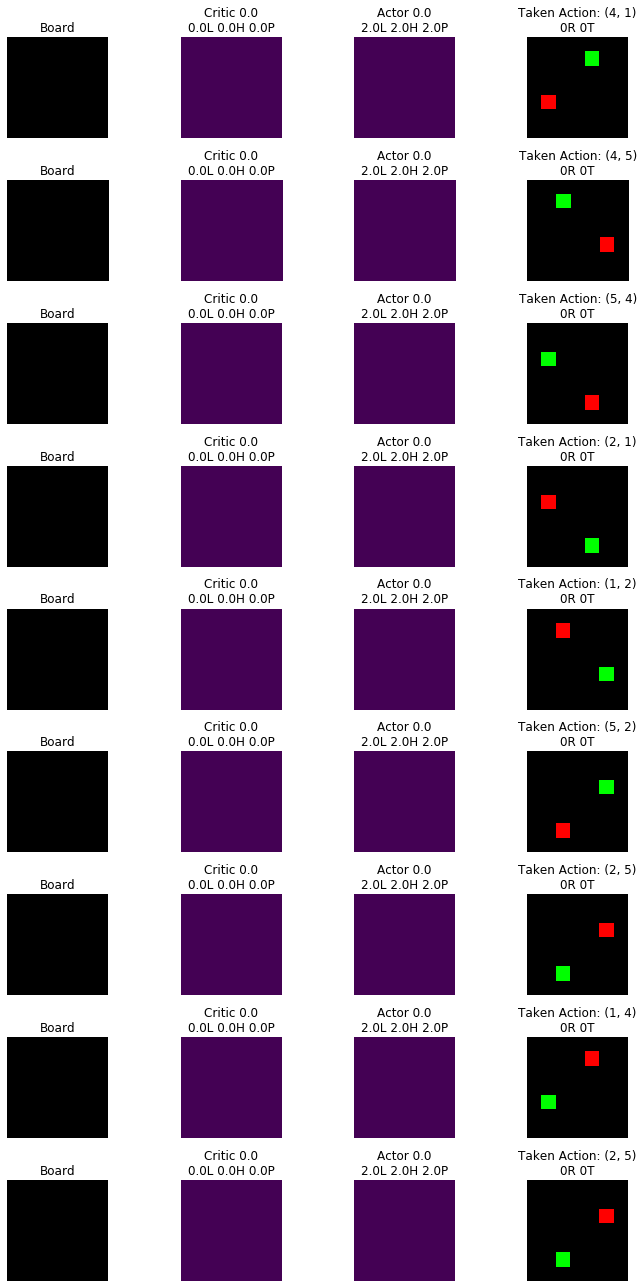

In [25]:
plt.show(sample_heatmaps(num_samples=8))

In [26]:
replay_mem.clear()

# Training Setup

In [27]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

### Metrics and Tensorboard

In [28]:
!rm -rf ./logs/

Metrics

In [29]:
metrics = {}
for metric_key in ['val_loss', 'move_loss']:
    metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)

Tensorboard

In [30]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['train', 'test']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

In [31]:
def log_to_tensorboard(episode):
    with summary_writers['train'].as_default():
        tf.summary.scalar('won', won.item(), step=episode)
        tf.summary.scalar('number of moves', num_steps, step=episode)
        tf.summary.scalar('val_loss', metrics['val_loss'].result(), step=episode)
        tf.summary.scalar('move_loss', metrics['move_loss'].result(), step=episode)
        tf.summary.scalar('epsilon', EPSILON, step=episode)
        
        # Plot samples of states and response heatmaps every so often
        if episode % 32 == 0:
            logging.debug("Sampling heatmaps...")
            fig = sample_heatmaps()
            tf.summary.image("model heat maps", utils.plot_to_image(fig), step=episode)

### Helper Functions

In [32]:
def get_action(policy, state, epsilon):
    """
    Gets an action (1D) based on exploration/exploitation
    """
    if state.shape[0] == 4:
        # State shape will be (BOARD_SIZE, BOARD_SIZE, 4)
        state = state.transpose(1,2,0)
            
    epsilon_choice = np.random.uniform()
    if epsilon_choice < epsilon:
        # Random move
        logging.debug("Exploring a random move")
        action = utils.random_action(state)
        
    else:
        # policy makes a move
        logging.debug("Exploiting policy's move")
        reshaped_state = state.reshape(1, BOARD_SIZE, BOARD_SIZE, 4).astype(np.float32)
        
        move_probs = forward_pass(reshaped_state, policy)
        action = utils.random_weighted_action(move_probs)
        
    return action

In [33]:
def get_value_for_action(move_val_distrs, actions):
    '''
    Actions should be a one hot array [batch size, ] array
    Get value from board_values based on action, or take the passing_values if the action is None
    '''
    one_hot_actions = tf.one_hot(actions, depth=BOARD_SIZE**2+1)
    assert move_val_distrs.shape == one_hot_actions.shape
    one_hot_move_values = move_val_distrs * one_hot_actions
    move_values = tf.reduce_sum(one_hot_move_values, axis=1)
    return move_values

In [34]:
mean_squared_error = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.SUM)

In [35]:
actor_opt = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE, ACTOR_BETA_1)
def update_actor():
    """
    Optimizes the actor over the whole replay memory
    """
    if len(replay_mem) < BATCH_SIZE:
        return
    
    batch_indices = np.arange(len(replay_mem) // BATCH_SIZE)
    np.random.shuffle(batch_indices)
    
    for batch_idx in batch_indices:
        states, actions, next_states, winners, terminals = get_batch_obs(index=batch_idx)
        batch_size = states.shape[0]
        
        # Actor
        state_val_distrs = forward_pass(states, critic)
        disavntg_val_distrs = tf.reduce_max(state_val_distrs, axis=1, keepdims=True) - state_val_distrs
        with tf.GradientTape() as tape:    
            move_prob_distrs = forward_pass(states, actor)
            assert move_prob_distrs.shape == disavntg_val_distrs.shape
            move_loss = (tf.reduce_sum(disavntg_val_distrs * move_prob_distrs) + 
                         0.1 * tf.reduce_sum(move_prob_distrs**2)) / batch_size
        
        metrics['move_loss'].update_state(move_loss)
        
        # compute and apply gradients
        gradients = tape.gradient(move_loss, actor.trainable_variables)
        actor_opt.apply_gradients(zip(gradients, actor.trainable_variables))

In [36]:
critic_opt = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE, CRITIC_BETA_1)
def update_critic():
    """
    Optimizes the critic over the whole replay memory
    """
    if len(replay_mem) < BATCH_SIZE:
        return
    
    batch_indices = np.arange(len(replay_mem) // BATCH_SIZE)
    np.random.shuffle(batch_indices)
    
    for batch_idx in batch_indices:
        states, actions, next_states, winners, terminals = get_batch_obs(index=batch_idx)
        batch_size = states.shape[0]
        
        # Critic
        with tf.GradientTape() as tape:
            move_val_distrs = forward_pass(states, critic)
            move_vals = get_value_for_action(move_val_distrs, actions)
            assert winners.shape == move_vals.shape
            val_loss = mean_squared_error(winners, move_vals) / batch_size
        
        metrics['val_loss'].update_state(val_loss)
        
        # compute and apply gradients
        gradients = tape.gradient(val_loss, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradients, critic.trainable_variables))

In [37]:
def play_a_game(episode, train, black_epsilon, white_epsilon):
    """
    Plays out a game, and iteratively updates the models at each step
    Returns the number of moves by the end of the game and the list 
    of rewards after every turn by the black player
    """
    
    # Basic setup
    done = False
    num_steps = 0
    state = go_env.reset()
    
    # Make it a numpy array so it can be passed to the replay memory by reference
    # That way, all events of the same game will have the same reward
    win = np.zeros(1)
    
    while True:
        # Black's move
        black_action = get_action(actor, state, epsilon=black_epsilon)            
        next_state, reward, done, info = go_env.step(utils.action_1d_to_2d(black_action, 
                                                                             BOARD_SIZE))
        num_steps += 1      
            
        if num_steps >= MAX_STEPS:
            # Max number of steps. End game
            reward = 1 if info['area']['b'] > info['area']['w'] else -1
            done = True
        if done:
            # Set the winner if we're done
            win[0] = reward
            if train:
                # Add to memory if training 
                # (black ended the game by making the last pass OR we hit the max number of steps)
                add_to_replay_mem(state, black_action, next_state, win, done)
            break
            
        # White's move
        # Swapped white and black channels
        white_action = get_action(opponent, next_state[[1,0,2,3]], epsilon=white_epsilon)
        next_state, reward, done, info = go_env.step(utils.action_1d_to_2d(white_action, 
                                                                             BOARD_SIZE))
        num_steps += 1
        
        if num_steps >= MAX_STEPS:
            # Max number of steps. End game
            reward = 1 if info['area']['b'] > info['area']['w'] else -1
            done = True
        if train:
            # Add to memory if training
            add_to_replay_mem(state, black_action, next_state, win, done)
        if done:
            # Set the winner if we're done
            win[0] = reward
            break
            
        state = next_state
    
    # Game ended
    return num_steps, win

# Train

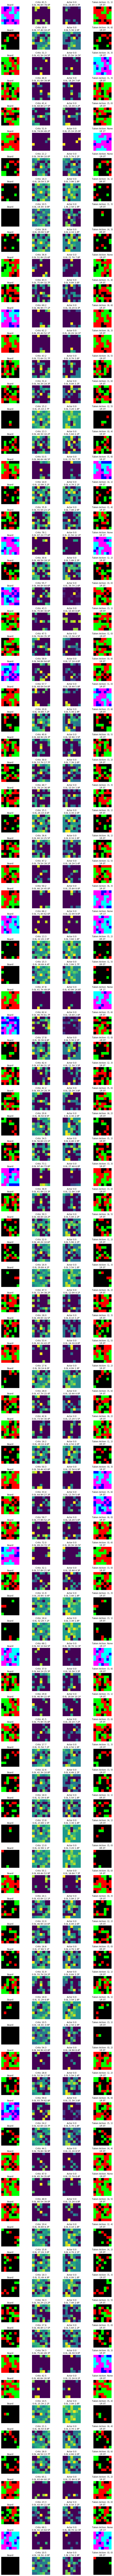

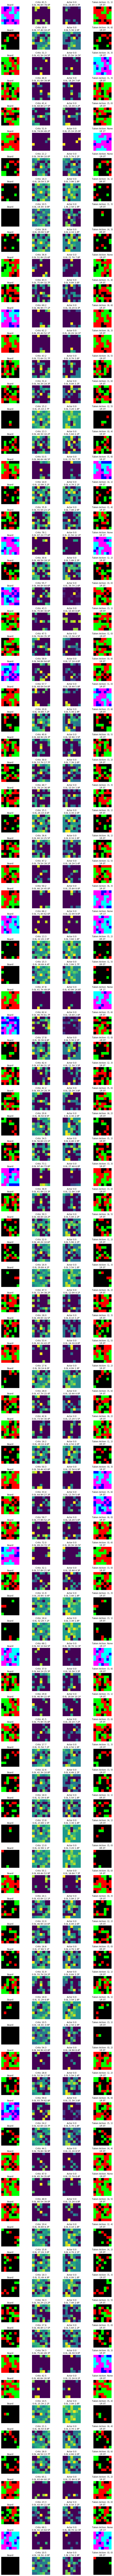

In [43]:
sample_heatmaps(num_samples=100)

In [38]:
for episode in tqdm(range(NUM_EPISODES)):
    # Update other models if appropriate
    logging.debug("Saving weights...")
    actor.save_weights(ACTOR_PATH)
    critic.save_weights(CRITIC_PATH)
    
    if episode % OPPONENT_UPDATE == 0:
        opponent.load_weights(ACTOR_PATH)
        
    # Train
    logging.debug("Playing a game...")
    num_steps, won = play_a_game(episode, train=True, black_epsilon=EPSILON, 
                                 white_epsilon=OPPONENT_EPSILON)
    
    # log results
    logging.debug("Logging metrics to tensorboard...")
    log_to_tensorboard(episode)
    
    # Reset all metrics
    logging.debug("Resetting metrics...")
    for metric in metrics.values():
        metric.reset_states()
    
    # Update the model
    logging.debug("Updating model...")
    update_critic()
    update_actor()  
    
    # Update exploration/exploitation
    if EPSILON > EPSILON_MIN:
        EPSILON *= EPSILON_DECAY
        logging.debug("Epsilon decayed to {}".format(EPSILON))

  0%|          | 3/20000 [00:02<4:15:14,  1.31it/s]WARNING: Logging before flag parsing goes to stderr.
W0805 18:52:06.995799 4479124928 deprecation.py:323] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
  2%|▏         | 332/20000 [03:30<3:11:41,  1.71it/s]

KeyboardInterrupt: 

# Evaluate

Get win percentage from 200 games

In [ ]:
def test_against_random_opponent():
    wins = []
    for _ in tqdm(range(200)):
        num_moves, win = play_a_game(episode=None, 
                                         train=False, 
                                         black_epsilon=0, 
                                         white_epsilon=1)
        wins.append(win)
    return np.average(wins)

In [ ]:
test_against_random_opponent()

Test against a pretrained AI

In [ ]:
# TODO

Play against our AI

In [44]:
go_env = gym.make('gym_go:go-v0', size=7)

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, epsilon=0)
    
#     state, reward, done, info = go_env.step(utils.action_1d_to_2d(action, BOARD_SIZE))
#     go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        if coords == 'r':
            go_env.reset()
            break
        if coords == 'p':
            go_env.step(None)
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)

    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   |   |
  -----------------------------
5 |   |   |   |   |   |   |   |
  -----------------------------
6 |   |   |   |   |   |   |   |
  -----------------------------

Enter coordinates separated by space (`q` to quit)
4 6
4 6
    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   |   |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 |   |   |   |   |   |   | B |
  -----------------------------
5 |   |   |   |   |   |   |   |
  --------------

Enter coordinates separated by space (`q` to quit)
0 6
0 6
    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   | B |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 | B | B |   |   |   |   | B |
  -----------------------------
5 | W | W | B |   |   |   | B |
  -----------------------------
6 | W |   |   |   |   | B | . |
  -----------------------------

Enter coordinates separated by space (`q` to quit)
p
    0   1   2   3   4   5   6
  -----------------------------
0 |   |   |   |   |   |   | B |
  -----------------------------
1 |   |   |   |   |   |   |   |
  -----------------------------
2 |   |   |   |   |   |   |   |
  -----------------------------
3 |   |   |   |   |   |   |   |
  -----------------------------
4 | B | B |   |   |   |   | B |
  -------------------------